In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from typing import Tuple, Sequence, Callable
import math

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Point net example
Just to show how this works, we check for a random point on a plane. 

In [11]:
num_points = 50

In [18]:
Point=Tuple[float, float]


def d(p1: Point, p2: Point) -> float:
    v = [(x-y)**2 for x,y in zip(p1, p2)]
    return np.sqrt(sum(v))

def d1(v1: Point, v2: Point) -> float:
     return np.sqrt(sum((v1-v2)**2))

def calculate_margin(points: Sequence[Point], labels: Sequence[int]) -> float:
    ones = filter(lambda a: a[1]==1,  zip(points, labels)) 
    zeros= filter(lambda a: a[1]==0,  zip(points, labels))
    min_dist = 10
    
    for o in ones:
        for z in zeros:
            if (dst:=d(o[0], z[0])) < min_dist:
                min_dist = dst
                
    return min_dist

def generate_net(points: Sequence[Point], gamma:float, d: Callable[[Point, Point], float]=d) -> Sequence[Point]:
    net = [points[np.random.randint(0, len(points))]]
    
    for p in points:
        insert = True
        for n in net: 
            if d(p, n) < gamma:
                insert = False
                break
        if insert:
            net.append(p)
        
    return net

def k_nearest(k, points, new_point, distance= d):
    byd = sorted(points, key=lambda lp: distance(lp, new_point))
    return byd[:k]

def plot_net(points, lables, gamma):
    gn = generate_net(points, gamma)
    nx, ny =list(zip(*gn))
    
    x, y =list(zip(*points))
    plt.scatter(nx, ny, s= 180,  c='r')
    plt.scatter(x, y, c=labels)
    

In [19]:
centers = [[1, 1], [-1, -1]]
X, y = make_blobs(n_samples=num_points, centers=centers, n_features=2, cluster_std=0.8, random_state=42)

points = list(zip(X[:, 0], X[:, 1]))
labels=y

In [20]:
g = calculate_margin(points, labels)
print(g)

1.4940589915175395


In [28]:
p = (1.61, 0.5)
gamma = g/2

kn = k_nearest(1, points, p)
net = generate_net(points, gamma)
nn = k_nearest(1, net, p)

print(f"Nearest neighbour using full point set ({len(points)}pts)\t=\t{kn}")
print(f"Nearest neighbour using point net      ({len(net)}pts)\t=\t{nn}")

Nearest neighbour using full point set (50pts)	=	[(1.397371322408986, 0.8893885590630523)]
Nearest neighbour using point net      (17pts)	=	[(1.397371322408986, 0.8893885590630523)]


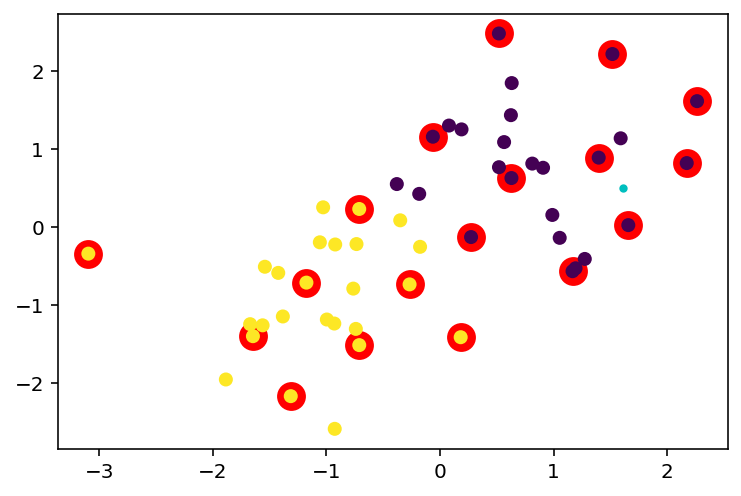

In [25]:
plot_net(points, y, gamma)
plt.scatter(p[0], p[1], s=10, c='c');

## app data
Some experiments using real data. Mostly discussing distance function (similarity)

In [2]:
from sklearn.model_selection import train_test_split
import tqdm

In [2]:
v = pd.read_csv('data/functions_encoded.csv')
labels = pd.read_csv('./data/labels_encoded.csv')

In [4]:
smp = v.sample(1000, random_state=42)
smp.head(3)

,apn,nf,usage
26929367,4464,573964,1
26806321,18538,528917,1
33237401,6909,625812,4


In [5]:
ap1 = 9104
ap2 = 18261

def get_app_functions(apid, v):
    return set(v[v['apn']==apid].nf.values)


def app_distance(apid1, apid2, v) -> float:
    nf1 = get_app_functions(apid=apid1, v=v)
    nf2 = get_app_functions(apid=apid2, v=v)
    return 0.5 - len(nf1.intersection(nf2))/(len(nf1)+len(nf2))

def ad(apid1, apid2,v ) -> float:
    p1 = get_app_functions(apid=apid1, v=v)
    p2 = get_app_functions(apid=apid2, v=v)
    
    a= len(p1.difference(p2)) + len(p2.difference(p1))
    return np.sqrt(a)

assert app_distance(ap1, ap1, v=smp) == 0.0
assert app_distance(ap1, ap2, v=smp) == 0.5
assert ad(ap1, ap2, v=smp) == ad(ap2, ap1, v=smp)
assert ad(ap1, ap1, v=smp) == ad(ap2, ap2, v=smp) == 0

In [6]:
funcs = v.groupby(by='apn')['nf'].apply(set)
funcs_smp = smp.groupby(by='apn')['nf'].apply(set)

In [7]:
def adf(apid1, apid2,funcs ) -> float:
    p1 = funcs[apid1]
    p2 = funcs[apid2]
    
    a= len(p1.difference(p2)) + len(p2.difference(p1))
    return np.sqrt(a)

adff = lambda x,y,z=funcs: adf(x,y, funcs)

assert adff(ap1,ap1) == adff(ap2, ap2) == 0
assert adff(ap1, ap2) == adff(ap2, ap1)

In [8]:
adff(ap1, ap2), ad(ap1, ap2, v)

(164.72401160729422, 164.72401160729422)

In [9]:
#lets call it curse of dimensionality: the more dimensions (funcs) the larger the distance
adf(ap1, ap2, funcs_smp), adf(ap1, ap2, funcs)

(1.7320508075688772, 164.72401160729422)

In [10]:
def create_net(gamma:float, v, distance=app_distance) -> Sequence[int]:
    apns = v.apn.unique()
    np.random.shuffle(apns)
    net = []

    for a in apns:
        insert = True
        for n in net: 
            if distance(a, n, v) < gamma:
                insert = False
                break
        if insert:
            net.append(a)
            
    return net

In [15]:
net = create_net(gamma = 1.4, v = smp, distance=lambda x,y,z: adf(x,y,funcs_smp))
#net

In [16]:
len(net), len(smp)

(845, 1000)

## Experiments with KNN
It only shows that KNN without labels (i.e., not classifying) does not make much sense in the current metric space. The nn found on net is in the same distance as the one foudn on the full dataset. Thoes nn can have however different id (different apps), the distance distribution is not on our side here. Many points are at the same distance.

In [11]:
def app_k_nearest(k, apps, new_app, distance):
    byd = sorted(apps, key=lambda lp: distance(lp, new_app))
    return byd[:k]

In [14]:
apns = smp.apn.unique()


In [20]:
mydistfunc = lambda x,y: adf(x, y, funcs_smp)
k=1000

In [27]:
train, test = train_test_split(smp)
p = test.iloc[2]['apn']
net = create_net(gamma=1.4, v=train, distance=lambda x,y,z: mydistfunc(x,y))

In [28]:
print(f"Nearest neigbours of {p} calcluated with whole dataset ({len(apns)} pts) ")
w = app_k_nearest(k=k, apps=apns, new_app = p, distance=mydistfunc)
print(f"closest neighbour: {w[0]} at {mydistfunc(p, w[1])}")  #exclude the seaerched point
dsts = {a: mydistfunc(p, a) for a in w if a!=p}
max_dst = max(dsts.values())
min_dst = min(dsts.values())
print(max_dst, min_dst)
print(f"Points at min distance: {len([a for a,b in dsts.items() if b==min_dst])}");

Nearest neigbours of 16687 calcluated with whole dataset (851 pts) 
closest neighbour: 16687 at 1.4142135623730951
2.23606797749979 1.4142135623730951
Points at min distance: 726


In [29]:
print(f"Nearest neigbours of {p} calcluated with net ({len(net)} pts)")
n = app_k_nearest(k=k, apps=net, new_app=p, distance=mydistfunc)
print(f"closest neighbour: {n[0]} at {mydistfunc(p, n[0])}")
net_dsts = {a: mydistfunc(p, a) for a in n}
net_max_dist = max(net_dsts.values())
net_min_dist = min(net_dsts.values())
print(net_max_dist, net_min_dist)
print(f"Points at min distance: {len([a for a,b in net_dsts.items() if b==net_min_dist])}");

Nearest neigbours of 16687 calcluated with net (657 pts)
closest neighbour: 18451 at 1.4142135623730951
2.23606797749979 1.4142135623730951
Points at min distance: 539


#### Distance distribution in set

In [37]:
from collections import Counter

# all pairwise distances except self to self
def calculate_distances(smp, distance: Callable)->Sequence[float]:
    distances = []
    for o in smp.apn.unique():
        for z in smp.apn.unique():
            if o == z:
                continue
            distances.append(distance(o, z, smp))
    return distances

#all distances with labels ignored:
distances = calculate_distances(smp, distance=lambda x,y,z: adf(x,y, funcs_smp))
c = Counter(distances)
print(c)

Counter({1.4142135623730951: 527798, 1.7320508075688772: 148302, 2.0: 37926, 2.23606797749979: 8238, 2.449489742783178: 954, 2.6457513110645907: 114, 2.8284271247461903: 6, 0.0: 6, 1.0: 6})


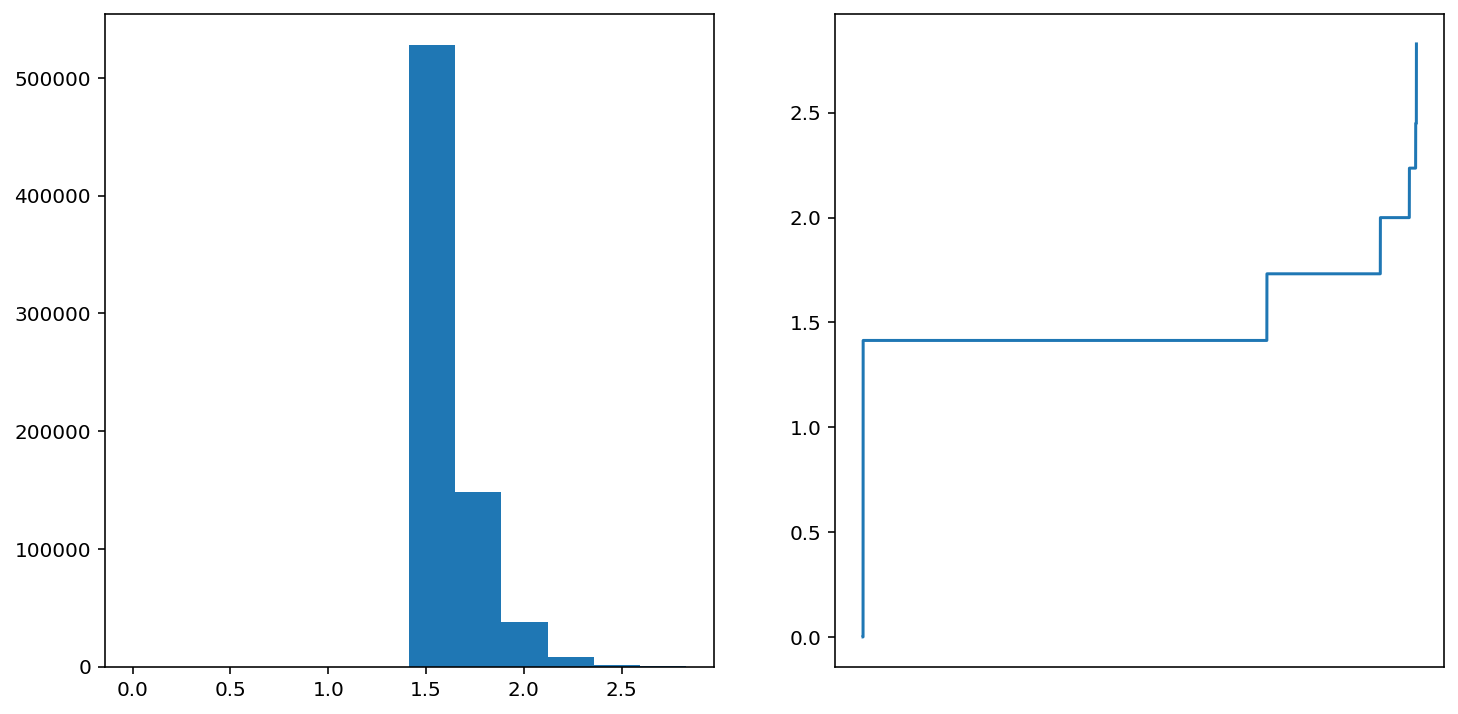

In [62]:
plt.subplots(1, 2, figsize=(12, 6))
plt.subplot(1,2,1)
plt.hist(distances, bins=12)
plt.subplot(1,2,2)
plt.plot(sorted(distances))
plt.xticks([]);


## With labels
* calcualte margin: minimal distance between differently labelled points
* check network performance

In [38]:
# split smp according to label (malicious or not)
def split_mal(smp, labels):
    benid = labels[labels.malware_label==False]['apn'].values
    malid = labels[labels.malware_label==True]['apn'].values

    mals = smp[smp.apn.isin(malid)]
    bi = smp[smp.apn.isin(benid)]
    
    return (mals, bi)

mals, bi = split_mal(smp, labels)
assert(mals.shape[0]+bi.shape[0] == smp.shape[0])

In [48]:
#minimal distance between differently labelled data points
def calculate_margin(smp, labels, distance: Callable) -> Tuple[float, Sequence[Tuple[int, int]]]:
    mals, beni = split_mal(smp, labels)
    print(f"Split finished: {mals.shape[0]} malicious, {beni.shape[0]} bening, {smp.shape[0]} overall")
    min_dist = float('inf')
    problematic = []

    for o in beni.apn.unique():
        for z in mals.apn.unique():
            if (d:=distance(o, z, smp)) < min_dist:
                if d == 0:
                    #print(f"Got minimal distance of 0 between {o}<->{z}. ignoring.")
                    problematic.append((o,z))
                else:
                    min_dist = d
                      
    #print(f"Problematic cases: {problematic}")
    return min_dist, problematic

In [50]:
# margin:
## funcs_smp uses only functions in sample
margin, _ = calculate_margin(smp, labels, distance=lambda x,y,z: adf(x,y, funcs_smp))
print(f"Minimal distance between differently labeled apps: {margin}")

Split finished: 297 malicious, 703 bening, 1000 overall
Minimal distance between differently labeled apps: 1.0


In [66]:
# difference between sample and full dataset. 
# two "identical" apps in sample (one and only funciton common), are different in full dataset
smp[smp.apn.isin([599, 4262])].shape, v[v.apn.isin([599, 4262])].shape

((2, 3), (14070, 3))

In [69]:
adf(599, 4262, funcs_smp), adf(599, 4262, funcs)

(0.0, 114.85643212288984)

In [51]:
import random

# sample number of apps, and included all their functions in the returned dataset
def mysample(v, sample_size):
    r = random.sample(list(v.apn.unique()), k=sample_size)
    #apns = v.apn.unique sample(sample_size, random_state=42)
    return v[v.apn.isin(r)][['apn', 'nf']]

In [52]:
def margins(v, labels, sample_size, problematic=[]):
    smp = mysample(v, sample_size) #v.sample(sample_size, random_state=42)
    print(f"sample created {smp.shape[0]/v.shape[0]:.2f}")
    if len(problematic)>0:
        print(f"Removing problematic {len(problematic)} apps")
        smp = smp[~smp.apn.isin(problematic)]
        
    funcs_smp = smp.groupby(by='apn')['nf'].apply(set)
    margin, problematic = calculate_margin(smp, labels, distance=lambda x,y,z: adf(x,y, funcs_smp))
    return margin, problematic

In [69]:
import itertools
problematic_pairs = [(20353, 11822), (20353, 5960), (20353, 5279), (20353, 23352), (20353, 4508), (20353, 15342), (20353, 2049), (20353, 15167), (20353, 22414), (20353, 9094), (20353, 25173), (20353, 7987), (20353, 10025), (20353, 5217), (20353, 9950), (20353, 24486), (20353, 17737), (20353, 17091), (20353, 24216), (20353, 23845), (20353, 6845), (20353, 25822), (20353, 4544), (20353, 5104), (20353, 1342), (20353, 16752), (20353, 17521), (20353, 5748), (20353, 21368), (20353, 23385), (20353, 24937), (20353, 10917), (20353, 27580), (20353, 17441), (20353, 16741), (20353, 4207), (20353, 8831), (20353, 22246), (20353, 15939), (20353, 21521), (20353, 14873), (20353, 4419), (20353, 23693), (20353, 12381), (20353, 23648), (20353, 12363), (20353, 22947), (20353, 22142), (20353, 17493), (20353, 13548), (20353, 14005), (20353, 14118), (20353, 17489), (20353, 11314), (20353, 23366), (20353, 24831), (20353, 12600), (20353, 22022), (20353, 17768), (20353, 23425), (20353, 21211), (20353, 3520), (20353, 10499), (20353, 16335), (20353, 26645), (20353, 16786), (20353, 4553), (20353, 15159), (20353, 10735), (20353, 2865), (20353, 440), (20353, 1441), (20353, 6307), (20353, 1503), (20353, 24948), (20353, 7846), (20353, 17565), (20353, 21973), (20353, 21833), (20353, 22007), (20353, 22165), (20353, 16663), (20353, 5525), (20353, 6969), (20353, 13086), (20353, 9158), (20353, 21508), (20353, 22015), (20353, 8245), (20353, 5230), (20353, 24770), (20353, 1785), (20353, 10814), (20353, 7186), (20353, 1638), (20353, 25910), (20353, 23679), (20353, 22521), (20353, 929), (20353, 465), (20353, 154), (20353, 24845), (20353, 5108), (20353, 22169), (20353, 15855), (20353, 22805), (20353, 10557), (20353, 4718), (20353, 23042), (20353, 16932), (20353, 805), (20353, 13492), (20353, 25587), (20353, 22874), (20353, 23334), (20353, 360), (20353, 2081), (20353, 23961), (20353, 22848), (20353, 16955), (20353, 6856), (20353, 2258), (20353, 27284), (20353, 13875)]
problematic = list(itertools.chain(*problematic_pairs))

In [70]:
for sample_size in [100, 500, 1000, 1500]:
    print(f"\nSample size: {sample_size}")
    margin, p2 = margins(v, labels, sample_size=1000, problematic=list(itertools.chain(*problematic_pairs)))
    
    print(f"Margin: {margin} calculated while ignoring {len(p2)} inconsitent cases")
    problematic_pairs = problematic_pairs +p2


Sample size: 100
sample created 0.10
Removing problematic 248 apps
Split finished: 967802 malicious, 2608661 bening, 3576463 overall
Margin: 1.0 calculated while ignoring 363 inconsitent cases

Sample size: 500
sample created 0.11
Removing problematic 974 apps
Split finished: 1070027 malicious, 2625701 bening, 3695728 overall
Margin: 1.0 calculated while ignoring 157 inconsitent cases

Sample size: 1000
sample created 0.10
Removing problematic 1288 apps
Split finished: 1088409 malicious, 2568196 bening, 3656605 overall
Margin: 1.0 calculated while ignoring 530 inconsitent cases

Sample size: 1500
sample created 0.10
Removing problematic 2348 apps
Split finished: 1098972 malicious, 2401596 bening, 3500568 overall
Margin: 1.0 calculated while ignoring 38 inconsitent cases


### Probalemtic cases
The dataset is not consitent. Some applications are identical in our dimension space (use exactly the same funciton). Yet they are differently classfied (malware and not).

In [168]:
def show_problematic(v, labels, id1, id2):
    print(f"App {id1} malware=[{labels[labels.apn==id1]['malware_label'].values[0]}] \tuses: {sorted(v[v.apn==id1]['nf'].values)}")
    print(f"App {id2} malware=[{labels[labels.apn==id2]['malware_label'].values[0]}] \tuses: {sorted(v[v.apn==id2]['nf'].values)}")
    

In [55]:
## Strengly some of the applications repead quite often in the problematic cases (a hint?)

In [206]:
for (a, b) in problematic_pairs:
    show_problematic(v, labels, a, b)
    print()

App 20353 malware=[False] 	uses: [101925, 178583]
App 11822 malware=[True] 	uses: [101925, 178583]

App 20353 malware=[False] 	uses: [101925, 178583]
App 5960 malware=[True] 	uses: [101925, 178583]

App 20353 malware=[False] 	uses: [101925, 178583]
App 5279 malware=[True] 	uses: [101925, 178583]

App 20353 malware=[False] 	uses: [101925, 178583]
App 23352 malware=[True] 	uses: [101925, 178583]

App 20353 malware=[False] 	uses: [101925, 178583]
App 4508 malware=[True] 	uses: [101925, 178583]

App 20353 malware=[False] 	uses: [101925, 178583]
App 15342 malware=[True] 	uses: [101925, 178583]

App 20353 malware=[False] 	uses: [101925, 178583]
App 2049 malware=[True] 	uses: [101925, 178583]

App 20353 malware=[False] 	uses: [101925, 178583]
App 15167 malware=[True] 	uses: [101925, 178583]

App 20353 malware=[False] 	uses: [101925, 178583]
App 22414 malware=[True] 	uses: [101925, 178583]

App 20353 malware=[False] 	uses: [101925, 178583]
App 9094 malware=[True] 	uses: [101925, 178583]

App 2

App 5525 malware=[True] 	uses: [101925, 178583]

App 20353 malware=[False] 	uses: [101925, 178583]
App 6969 malware=[True] 	uses: [101925, 178583]

App 20353 malware=[False] 	uses: [101925, 178583]
App 13086 malware=[True] 	uses: [101925, 178583]

App 20353 malware=[False] 	uses: [101925, 178583]
App 9158 malware=[True] 	uses: [101925, 178583]

App 20353 malware=[False] 	uses: [101925, 178583]
App 21508 malware=[True] 	uses: [101925, 178583]

App 20353 malware=[False] 	uses: [101925, 178583]
App 22015 malware=[True] 	uses: [101925, 178583]

App 20353 malware=[False] 	uses: [101925, 178583]
App 8245 malware=[True] 	uses: [101925, 178583]

App 20353 malware=[False] 	uses: [101925, 178583]
App 5230 malware=[True] 	uses: [101925, 178583]

App 20353 malware=[False] 	uses: [101925, 178583]
App 24770 malware=[True] 	uses: [101925, 178583]

App 20353 malware=[False] 	uses: [101925, 178583]
App 1785 malware=[True] 	uses: [101925, 178583]

App 20353 malware=[False] 	uses: [101925, 178583]
App 10

### Net

No with a calculated margin we can create a sensible point net

In [103]:
def classify_app(appid, labels):
    return labels[labels.apn==appid]['malware_label'].values[0]

def verify_point(appid, net, labels, k, distance):
    print(f"Nearest neigbours of {appid} calcluated with ({len(net)} pts)")
    n = app_k_nearest(k=k, apps=net, new_app=appid, distance=distance)
    if n[0] == appid:
        n.remove(appid)
        
    print(f"app {appid} is: {classify_app(appid, labels)}")
    print(f"closest neighbour: {n[0]} is {classify_app(n[0], labels)}")
    
    #net_dsts = {a: mydistfunc(p, a) for a in n}
    #net_max_dist = max(net_dsts.values())
    #net_min_dist = min(net_dsts.values())
    #print(net_max_dist, net_min_dist)
    #print(f"Points at min distance: {len([a for a,b in net_dsts.items() if b==net_min_dist])}")

def generate_net(v, labels, sample_size, problematic_pairs):
    smp = mysample(v, sample_size) #v.sample(sample_size, random_state=42)
    print(f"sample created {smp.shape[0]/v.shape[0]:.2f}")
    if len(problematic_pairs)>0:
        problematic = list(itertools.chain(*problematic_pairs))
        print(f"Removing problematic {len(problematic)} apps")
        smp = smp[~smp.apn.isin(problematic)]

    funcs_smp = smp.groupby(by='apn')['nf'].apply(set)
    margin, problematic_prs = calculate_margin(smp, labels, distance=lambda x,y,z: adf(x,y, funcs_smp))
    gamma = margin / 2.0

    
    problematic = list(itertools.chain(*(problematic_pairs+problematic_prs)))
    print(f"Second removal of problematics {len(problematic)}")
    smp = smp[~smp.apn.isin(problematic)]
    #I guess we don't need new dsitance matrix funcs_smp (only removal)
    
    
    train, test = train_test_split(smp)
    print(f"Calculating net with {gamma}")
    net = create_net(gamma=gamma, v=train, distance=lambda x,y,z: adff(x,y, funcs_smp))
    print(f"Net {len(net)} created")
    
    return train, test, net

In [84]:
train, test, net = generate_net(v, labels, 100, problematic_pairs)

sample created 0.01
Removing problematic 2424 apps
Split finished: 103197 malicious, 208585 bening, 311782 overall
Second removal of problematics 2424
Calculating net with 0.7071067811865476
Net 74 created


In [94]:
someappid = test.iloc[0]['apn']

In [104]:
verify_point(someappid, net, labels, k=10, distance=lambda x, y: adff(x, y, funcs_smp ))

Nearest neigbours of 12927 calcluated with (74 pts)
app 12927 is: True
closest neighbour: 18639 is False
